In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 100 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01
elasticity_params_dict = {
    'a_r': 1.5,  # Rider acceptance probability parameter
    'b_r': -0.2,  # Rider acceptance probability parameter

    # short-term driver's elasticity is around -0.05 as well
    'a_d': 1.5,  # Driver acceptance probability parameter
    'b_d': -0.3,  # Driver acceptance probability parameter

    'a_lambda': -0.003,
    # avg. daily exposed price over 100 weeks is 22.5672
    'b_lambda': 22.5672,
}
data_save_path = r'../data/100_weeks_default_params/'

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
total_weeks = 100

stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params, elasticity_params_dict, data_save_path)
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open(os.path.join(data_save_path, 'demand_week_'+str(w)+'.json'), 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open(os.path.join(data_save_path, 'supply_week_'+str(w)+'.json'), 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        # # Save each dictionary as a JSON object in a JSON file
        with open(os.path.join(data_save_path, 'exposed_prices_week_'+str(w)+'.json'), 'w') as json_file:
            json.dump(simulation_this_week.exposed_prices, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        #simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

        simulation_this_week.update_lambda_longterm_elasticity()

100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


In [6]:
#lambda will be fix if we don't sample from gamma distributions
lambda_riders_df = pd.DataFrame({'lambda_riders': simulation_this_week.lambda_riders.tolist()})

In [7]:
lambda_riders_df.describe()

,lambda_riders
count,1000.000000
mean,0.857638
std,0.125063
min,0.732638
25%,0.732638
50%,0.857638
75%,0.982638
max,0.982638


In [8]:
weekly_sim_log_df = pd.read_json(os.path.join(data_save_path, 'logfile_matched_trips_week_0_.log'), lines=True)

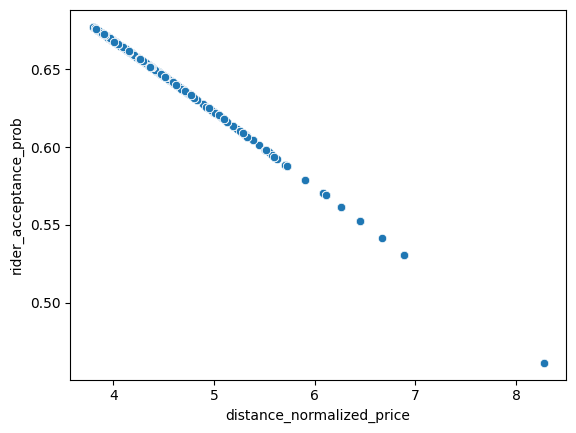

In [9]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [10]:
slope, intercept, r_value, p_value, std_err = linregress(weekly_sim_log_df['distance_normalized_price']
                                                         , weekly_sim_log_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.04667935544736686,
 0.85528130696607,
 -0.9997473079975066,
 0.0,
 3.055462180495345e-05)

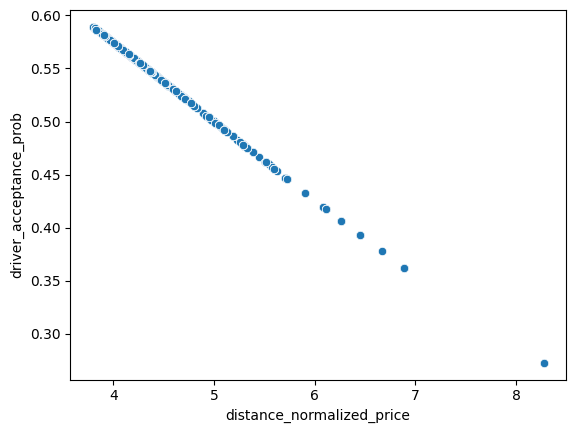

In [11]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='driver_acceptance_prob')
plt.show()

In [12]:
slope, intercept, r_value, p_value, std_err = linregress(weekly_sim_log_df['distance_normalized_price']
                                                         , weekly_sim_log_df['driver_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.0740154705366365,
 0.8704209820324351,
 -0.9998749310567727,
 0.0,
 3.408097253226606e-05)

In [13]:
weekly_sim_log_df.shape

(1182, 12)

In [14]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

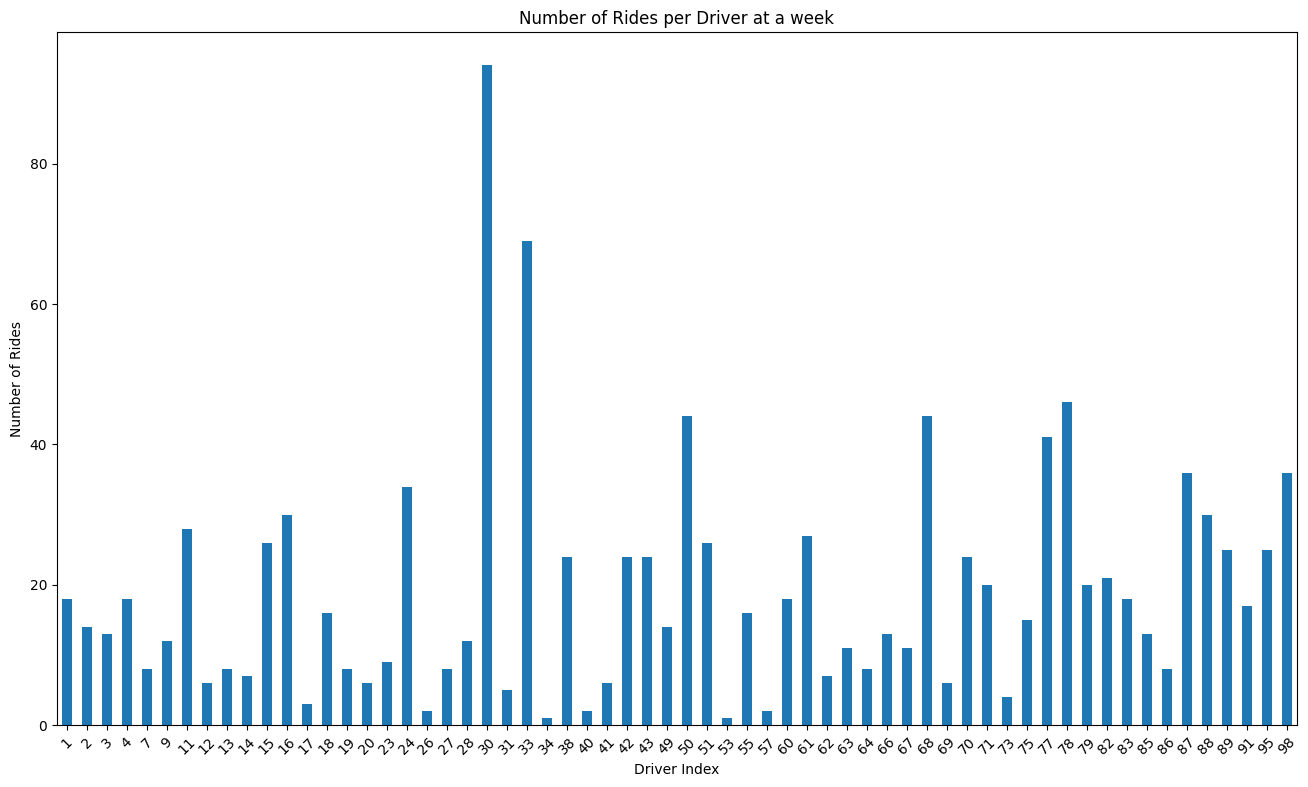

In [15]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 25.89 riders per week

In [16]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

19.06451612903226

In [17]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.448429780033841, 0.6476314720812183)

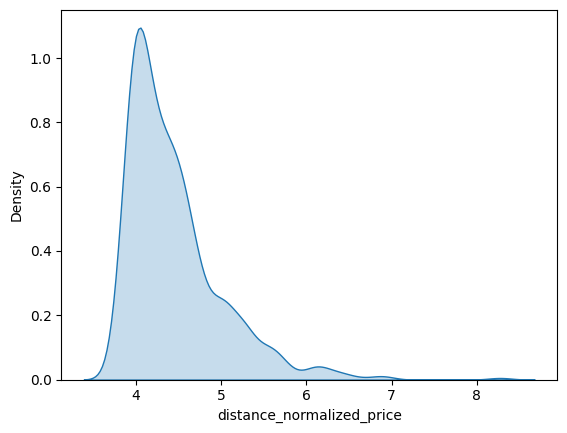

In [18]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

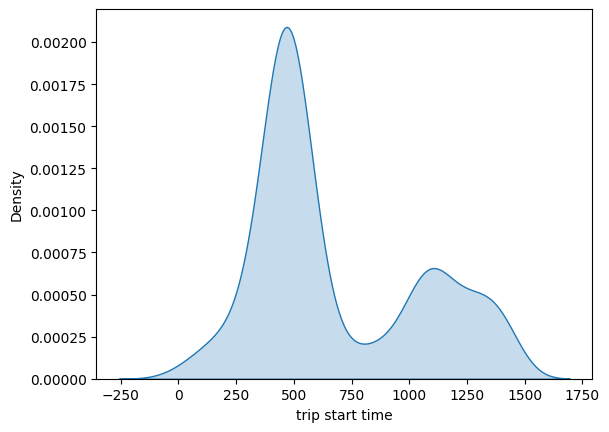

In [19]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

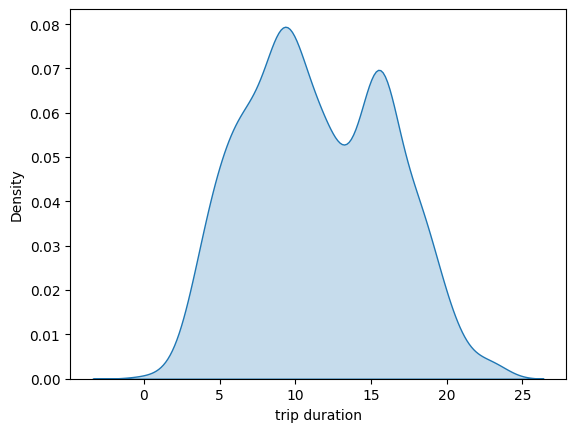

In [20]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

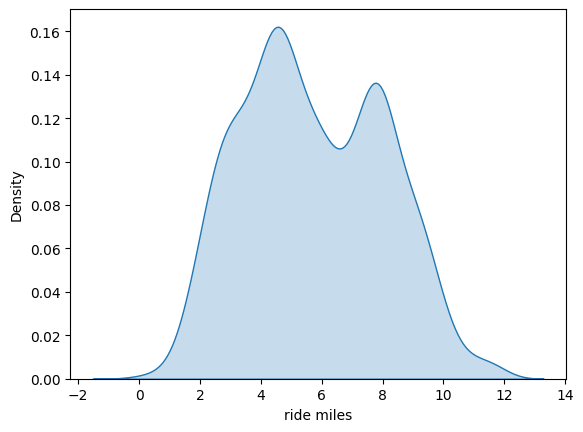

In [21]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

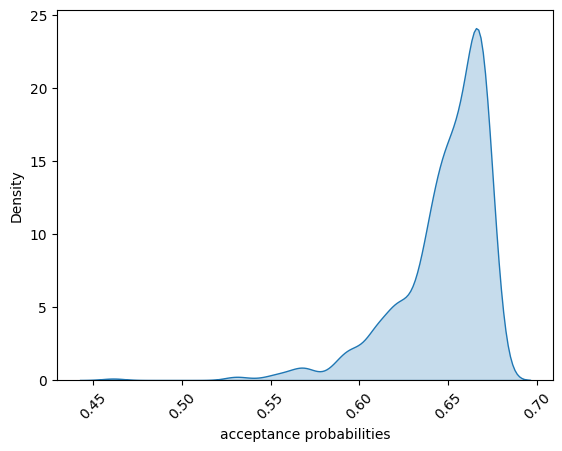

In [22]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

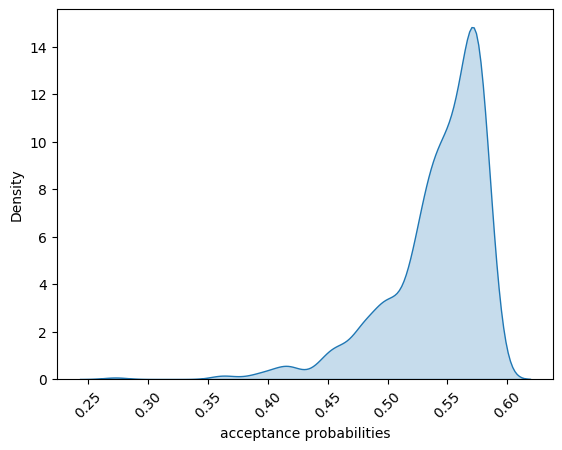

In [23]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [24]:
daily_avg_price_lst, daily_total_requests = [], []
for i in range(100):
    prices_df = pd.read_json(os.path.join(data_save_path, 'exposed_prices_week_'+str(i)+'.json'))
    requests_df = pd.read_json(os.path.join(data_save_path, 'demand_week_'+str(i)+'.json'))
    daily_avg_price_lst.append(prices_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [25]:
daily_avg_price_lst[0]

23.22795857908847

In [26]:
sum(daily_avg_price_lst[:25])/len(daily_avg_price_lst[:25])

22.700593578710354

In [27]:
sum(daily_avg_price_lst[:50])/len(daily_avg_price_lst[:50]), sum(daily_avg_price_lst[:75])/len(daily_avg_price_lst[:75])

(22.664186018654654, 22.62483485527595)

In [28]:
sum(daily_avg_price_lst)/len(daily_avg_price_lst)

22.596026498708458

In [29]:
prices_df.head(2)

,price_of_ride,distance_normalized_price,trip_duration,rider_acceptance_prob,driver_acceptance_prob
0,30.3268,4.0505,15,0.6659,0.5707
1,18.5100,4.6339,8,0.6395,0.5274


In [30]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [31]:
long_term_rider_elasticity_df.daily_avg_price.describe()

count    100.000000
mean      22.596026
std        0.347627
min       21.741751
25%       22.327423
50%       22.622774
75%       22.846676
max       23.390950
Name: daily_avg_price, dtype: float64

In [32]:
long_term_rider_elasticity_df.daily_total_requests.describe()

count    100.000000
mean     878.730000
std       34.029059
min      814.000000
25%      852.000000
50%      877.500000
75%      902.000000
max      957.000000
Name: daily_total_requests, dtype: float64

In [33]:
#long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [34]:
#long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [35]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(22.596026498708465, 878.73)

In [47]:
long_term_rider_elasticity_df.sort_values(['daily_avg_price']).tail(10)

,daily_avg_price,daily_total_requests
24,22.947939,852
1,22.962226,842
61,22.994090,877
64,22.994891,852
57,23.040377,875
89,23.125796,822
0,23.227959,893
69,23.299033,850
32,23.327123,854
48,23.390950,857


In [51]:
reference_row1 = long_term_rider_elasticity_df.loc[31]
reference_row2 = long_term_rider_elasticity_df.loc[48]

In [52]:
(reference_row2.daily_avg_price - reference_row1.daily_avg_price)/reference_row1.daily_avg_price, \
(reference_row2.daily_total_requests - reference_row1.daily_total_requests)/reference_row1.daily_total_requests

(0.0630327023609886, -0.033821871476888386)

### A 6% increase of daily avg. exposed price causes a 3.3% decrease of daily number of requests

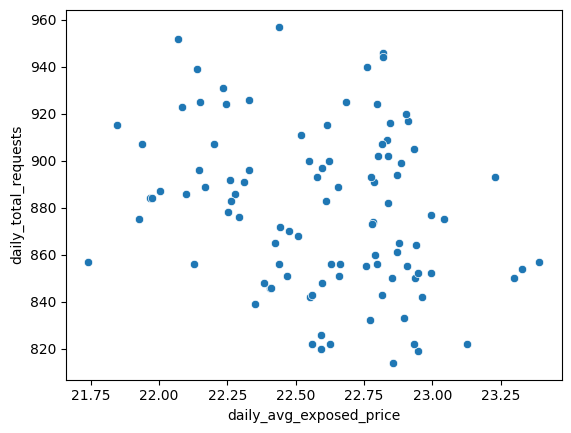

In [39]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.xlabel('daily_avg_exposed_price')
plt.show()

In [40]:
long_term_rider_elasticity_df['daily_avg_price'].mean(), long_term_rider_elasticity_df['daily_total_requests'].mean()

(22.596026498708465, 878.73)

In [41]:
1/long_term_rider_elasticity_df['daily_avg_price'].mean(), -67.67409299173185/long_term_rider_elasticity_df['daily_total_requests'].mean()

(0.04425556856455083, -0.07701352291572139)

### 1 unit change of avg. exposed price cause -32 change of daily total requests

In [42]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-26.29163892693483,
 1472.8165698874946,
 -0.268584488584897,
 0.006894171175135551,
 9.52501077377359)

### as below, the ride share company makes $7.12 per ride

In [43]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(24.39, 28831.0018)

In [44]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

7.32

### save data to df

In [53]:
data_save_path

'../data/100_weeks_default_params/'

In [54]:
df_save_path = '../data/100_weeks_default_params_dataframes'

In [55]:
for filename in tqdm(os.listdir(data_save_path)):
    try:
        if filename.endswith(".log"):
            this_df = pd.read_json(os.path.join(data_save_path, filename), lines=True)
            save_filename = filename.replace('.log', '.csv')
        else:
            this_df = pd.read_json(os.path.join(data_save_path, filename))
            save_filename = filename.replace('.json', '.csv')
        this_df.to_csv(os.path.join(df_save_path, save_filename))
    except:
        print(filename)

 14%|█▍        | 58/401 [00:00<00:02, 162.16it/s]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte